# Lesson 30 demo part 1: optimizer comparison

This notebook compares four common optimizers used in deep learning:

1. **SGD** (Stochastic Gradient Descent) - vanilla, no momentum
2. **SGD + Momentum** - SGD with momentum=0.9
3. **RMSprop** - Adaptive learning rate per parameter
4. **Adam** - Adaptive learning rate + momentum (most popular)

We'll see how they differ in:
- **Part 1**: Batch size effect (true SGD vs mini-batch)
- **Part 2**: Momentum effect (SGD with different momentum values)
- **Part 3**: Convergence speed at the same learning rate
- **Part 4**: Sensitivity to learning rate choice

> **Note**: PyTorch's "SGD" optimizer is a bit of a misnomer—it's only true *stochastic* gradient descent when batch_size=1. With larger batches, it's technically *mini-batch* gradient descent.

In [1]:
# Standard library imports
import time
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Custom package import
from cifar10_tools.pytorch import train_model

# Set random seed for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Configuration
batch_size = 10000  # Default for validation loader
print_every = 10

# Part 1 settings (batch size comparison)
batch_sizes_part1 = [1, 4, 16, 64, 256, 1024]
n_samples_part1 = 1024  # Full dataset -validation = 40000
n_epochs_part1 = 50
lr_part1 = 0.01

# Part 2 settings (momentum comparison)
momentum_values = [0.0, 0.5, 0.9, 0.95, 0.99]
batch_size_part2 = 16
n_epochs_part2 = 50
lr_part2 = 0.01

# Part 3 settings (optimizer comparison)
n_epochs_part3 = 50
lr_part3 = 0.001

# Part 4 settings (learning rate sensitivity)
n_epochs_part4 = 10
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Optimizer configurations
optimizer_configs = {
    'SGD': lambda params, lr: optim.SGD(params, lr=lr),
    'SGD+Momentum': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    'RMSprop': lambda params, lr: optim.RMSprop(params, lr=lr),
    'Adam': lambda params, lr: optim.Adam(params, lr=lr)
}

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Load CIFAR-10 data (grayscale)

In [4]:
# Data directory
data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)

# Grayscale transform for faster training
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 170M/170M [00:02<00:00, 59.2MB/s] 


Training samples: 50000
Test samples: 10000


In [5]:
# Preload to GPU
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)
X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Train/val split (80/20)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

# Validation loader (fixed batch size)
val_loader = DataLoader(
    torch.utils.data.TensorDataset(X_val, y_val), 
    batch_size=batch_size, 
    shuffle=False
)

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')

X_train: torch.Size([40000, 1, 32, 32])
X_val: torch.Size([10000, 1, 32, 32])


## 2. Variable batch size training data loader

In [6]:
def create_train_loader(batch_size: int, n_samples: int = None) -> DataLoader:
    '''Create a training DataLoader with specified batch size and optional sample limit.'''
    
    if n_samples is not None and n_samples < len(X_train):

        # Use a random subset
        indices = torch.randperm(len(X_train))[:n_samples]
        X_subset = X_train[indices]
        y_subset = y_train[indices]
        dataset = torch.utils.data.TensorDataset(X_subset, y_subset)

    else:
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 3. Define CNN architecture

We use a simple 1-block grayscale CNN for fast training.

In [7]:
def create_cnn():
    '''Create a fresh 1-block grayscale CNN.'''

    return nn.Sequential(
    
        # Conv block: 1 -> 32 channels, 32x32 -> 8x8
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.5),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.5),
        
        # Classifier
        nn.Flatten(),
        nn.Linear(32 * 8 * 8, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

# Show model summary
model = create_cnn().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model parameters: {params:,}')
del model

Model parameters: 273,258


## 4. Training function

In [8]:
def train_with_optimizer(
        optimizer_name: str,
        learning_rate: float,
        n_epochs: int,
        print_every: int,
        train_loader: DataLoader = None,
        batch_size: int = 10000,
        n_samples: int = None
) -> dict:
    '''Train a fresh model with the specified optimizer and return history.'''
    
    # Create train loader if not provided
    if train_loader is None:
        train_loader = create_train_loader(batch_size, n_samples)
    
    # Create fresh model with same initialization
    torch.manual_seed(315)
    model = create_cnn().to(device)
    
    # Create optimizer and criterion
    optimizer = optimizer_configs[optimizer_name](model.parameters(), learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=n_epochs,
        print_every=print_every
    )
    
    return history

---

## Part 1: Batch size effect (true SGD vs mini-batch)

PyTorch's `SGD` optimizer is only *true* stochastic gradient descent when `batch_size=1`. 
With larger batches, it's mini-batch gradient descent.

Let's see how batch size affects training with vanilla SGD (no momentum):
- **batch_size=1**: True SGD - update after every sample (noisy but can escape local minima)
- **batch_size=4, 16, 64**: Mini-batch - smoother gradients, faster per epoch

> We use a subset of the training data (`n_samples_part1`) to keep runtime reasonable.

In [9]:
%%time

print(f'Using {n_samples_part1} samples')

# Select data sample once for fair comparison across batch sizes
subset_indices = torch.randperm(len(X_train))[:n_samples_part1]
X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]

results_part1 = {}

for bs in batch_sizes_part1:
    
    # Create loader from the same subset with different batch size
    train_loader_part1 = DataLoader(
        torch.utils.data.TensorDataset(X_train_subset, y_train_subset),
        batch_size=bs,
        shuffle=True
    )

    print(f'\nTraining with batch_size={bs} ({len(train_loader_part1)} batches/epoch)')
    
    start = time.time()
    results_part1[bs] = train_with_optimizer(
        'SGD', lr_part1, n_epochs_part1, 
        print_every=print_every, 
        train_loader=train_loader_part1
    )
    elapsed = time.time() - start
    
    final_acc = results_part1[bs]['val_accuracy'][-1]
    print(f'-> Final val acc: {final_acc:.2f}% (took {elapsed:.1f}s)')

print()

Using 1024 samples

Training with batch_size=1 (1024 batches/epoch)
Epoch 1/50 - loss: 2.3429 - accuracy: 8.98% - val_loss: 2.3029 - val_accuracy: 9.78%
Epoch 10/50 - loss: 2.2732 - accuracy: 12.70% - val_loss: 2.2744 - val_accuracy: 11.44%
Epoch 20/50 - loss: 2.0004 - accuracy: 27.05% - val_loss: 2.1402 - val_accuracy: 21.45%
Epoch 30/50 - loss: 1.6697 - accuracy: 38.48% - val_loss: 2.1236 - val_accuracy: 24.86%
Epoch 40/50 - loss: 1.4528 - accuracy: 48.93% - val_loss: 2.0882 - val_accuracy: 26.10%
Epoch 50/50 - loss: 1.1534 - accuracy: 58.89% - val_loss: 2.1450 - val_accuracy: 25.86%

Training complete.
-> Final val acc: 25.86% (took 311.0s)

Training with batch_size=4 (256 batches/epoch)
Epoch 1/50 - loss: 2.3047 - accuracy: 13.67% - val_loss: 2.2028 - val_accuracy: 19.43%
Epoch 10/50 - loss: 1.8809 - accuracy: 31.05% - val_loss: 1.8670 - val_accuracy: 33.27%
Epoch 20/50 - loss: 1.5914 - accuracy: 43.26% - val_loss: 1.7615 - val_accuracy: 36.05%
Epoch 30/50 - loss: 1.3975 - accuracy

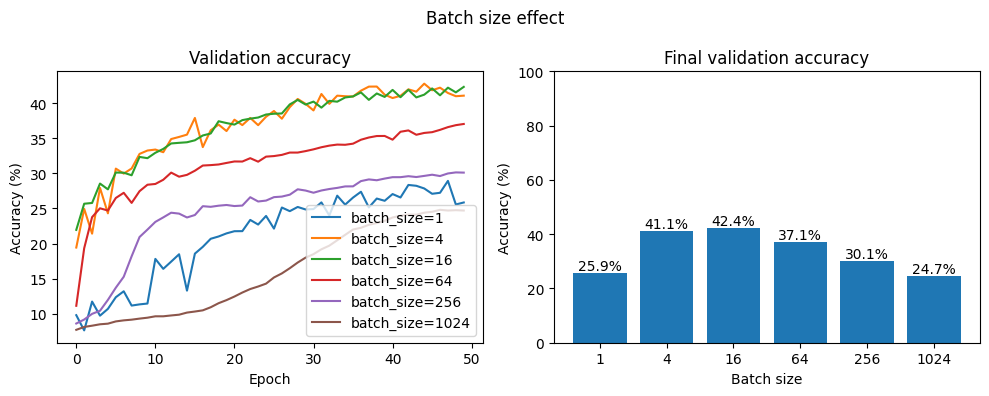

In [ ]:
# Plot part 1 results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle('Effect of batch size')

# Validation accuracy over epochs
axes[0].set_title('Validation accuracy')

for bs, history in results_part1.items():
    axes[0].plot(history['val_accuracy'], label=f'batch_size={bs}')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()

# Final accuracy bar chart
axes[1].set_title('Final validation accuracy')

batch_sizes = list(results_part1.keys())
final_accs = [results_part1[bs]['val_accuracy'][-1] for bs in batch_sizes]

bars = axes[1].bar([str(bs) for bs in batch_sizes], final_accs)
axes[1].set_xlabel('Batch size')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim(0, 100)

# Add value labels
for bar, acc in zip(bars, final_accs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{acc:.1f}%', ha='center')

plt.tight_layout()
plt.show()

---

## Part 2: Momentum effect (SGD with different momentum values)

Momentum helps SGD accelerate in relevant directions and dampen oscillations. Let's see how different momentum values affect training:
- **momentum=0.0**: Vanilla SGD (no momentum)
- **momentum=0.5**: Light momentum
- **momentum=0.9**: Standard momentum (commonly used)
- **momentum=0.95**: High momentum
- **momentum=0.99**: Very high momentum (can overshoot)

We use batch_size=16 and lr=0.01 (from Part 1's good settings).

In [11]:
%%time

# Create train loader for Part 2
train_loader_part2 = create_train_loader(batch_size_part2)

# Dictionary to store results for Part 2
results_part2 = {}

for momentum in momentum_values:

    print(f'\nTraining with momentum={momentum}')
    
    # Create fresh model
    torch.manual_seed(42)
    model = create_cnn().to(device)
    
    # Create optimizer with specified momentum
    optimizer = optim.SGD(model.parameters(), lr=lr_part2, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    start = time.time()
    results_part2[momentum] = train_model(
        model=model,
        train_loader=train_loader_part2,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=n_epochs_part2,
        print_every=print_every
    )
    elapsed = time.time() - start
    
    final_acc = results_part2[momentum]['val_accuracy'][-1]
    print(f'-> Final val acc: {final_acc:.2f}% (took {elapsed:.1f}s)')

print()


Training with momentum=0.0
Epoch 1/50 - loss: 1.8974 - accuracy: 30.34% - val_loss: 1.5768 - val_accuracy: 45.38%
Epoch 10/50 - loss: 1.2988 - accuracy: 54.41% - val_loss: 1.0809 - val_accuracy: 62.65%
Epoch 20/50 - loss: 1.1817 - accuracy: 58.90% - val_loss: 0.9931 - val_accuracy: 66.75%
Epoch 30/50 - loss: 1.1266 - accuracy: 60.63% - val_loss: 0.9447 - val_accuracy: 67.91%
Epoch 40/50 - loss: 1.0869 - accuracy: 61.84% - val_loss: 0.9152 - val_accuracy: 69.29%
Epoch 50/50 - loss: 1.0588 - accuracy: 63.05% - val_loss: 0.8787 - val_accuracy: 69.78%

Training complete.
-> Final val acc: 69.78% (took 540.5s)

Training with momentum=0.5
Epoch 1/50 - loss: 1.8950 - accuracy: 30.20% - val_loss: 1.5671 - val_accuracy: 45.09%
Epoch 10/50 - loss: 1.2890 - accuracy: 55.05% - val_loss: 1.0821 - val_accuracy: 64.35%
Epoch 20/50 - loss: 1.1827 - accuracy: 58.89% - val_loss: 0.9976 - val_accuracy: 66.27%
Epoch 30/50 - loss: 1.1301 - accuracy: 60.95% - val_loss: 0.9327 - val_accuracy: 68.93%
Epoch 4

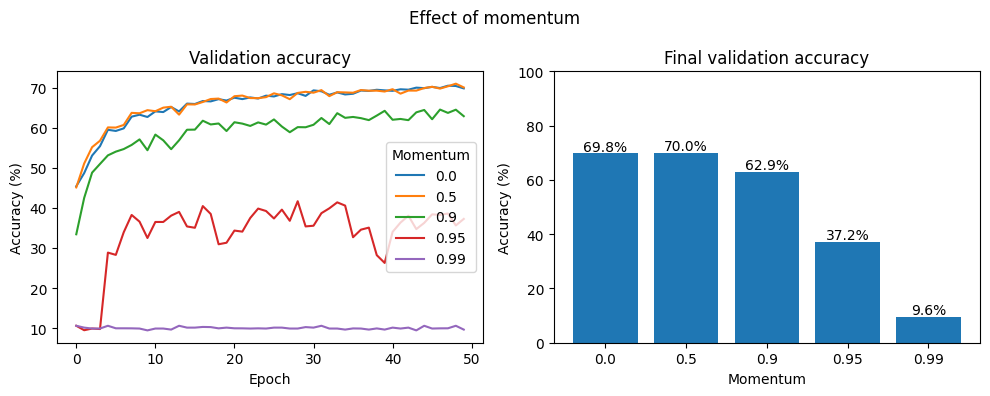

In [12]:
# Plot part 2 results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle(f'Effect of momentum')

# Validation accuracy over epochs
axes[0].set_title('Validation accuracy')

for momentum, history in results_part2.items():
    axes[0].plot(history['val_accuracy'], label=momentum)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend(title='Momentum')

# Final accuracy bar chart
axes[1].set_title('Final validation accuracy')

momentums = list(results_part2.keys())
final_accs = [results_part2[m]['val_accuracy'][-1] for m in momentums]

bars = axes[1].bar([str(m) for m in momentums], final_accs)
axes[1].set_xlabel('Momentum')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim(0, 100)

# Add value labels
for bar, acc in zip(bars, final_accs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{acc:.1f}%', ha='center')

plt.tight_layout()
plt.show()

---

## Part 3: Optimizer comparison (same learning rate)

Now we compare all four optimizers with the **same learning rate (0.001)** to see how they differ in convergence speed.

We'll use a larger batch size for efficiency.

In [13]:
%%time

# Create train loader with default batch size for Parts 3 & 4
train_loader = create_train_loader(batch_size)

results_part3 = {}

for name in optimizer_configs.keys():

    print(f'\nTraining with {name}')

    results_part3[name] = train_with_optimizer(
        name, lr_part3, n_epochs_part3, print_every, train_loader=train_loader
    )

print()


Training with SGD
Epoch 1/50 - loss: 2.4251 - accuracy: 9.84% - val_loss: 2.3054 - val_accuracy: 8.12%
Epoch 10/50 - loss: 2.3770 - accuracy: 10.64% - val_loss: 2.2986 - val_accuracy: 10.35%
Epoch 20/50 - loss: 2.3555 - accuracy: 10.57% - val_loss: 2.2884 - val_accuracy: 13.76%
Epoch 30/50 - loss: 2.3389 - accuracy: 11.19% - val_loss: 2.2822 - val_accuracy: 15.90%
Epoch 40/50 - loss: 2.3264 - accuracy: 11.67% - val_loss: 2.2774 - val_accuracy: 17.11%
Epoch 50/50 - loss: 2.3136 - accuracy: 12.22% - val_loss: 2.2732 - val_accuracy: 18.07%

Training complete.

Training with SGD+Momentum
Epoch 1/50 - loss: 2.4232 - accuracy: 9.84% - val_loss: 2.3050 - val_accuracy: 8.22%
Epoch 10/50 - loss: 2.2899 - accuracy: 13.55% - val_loss: 2.2753 - val_accuracy: 18.86%
Epoch 20/50 - loss: 2.2389 - accuracy: 16.61% - val_loss: 2.2226 - val_accuracy: 25.73%
Epoch 30/50 - loss: 2.1819 - accuracy: 19.33% - val_loss: 2.1598 - val_accuracy: 27.43%
Epoch 40/50 - loss: 2.1315 - accuracy: 21.60% - val_loss: 2

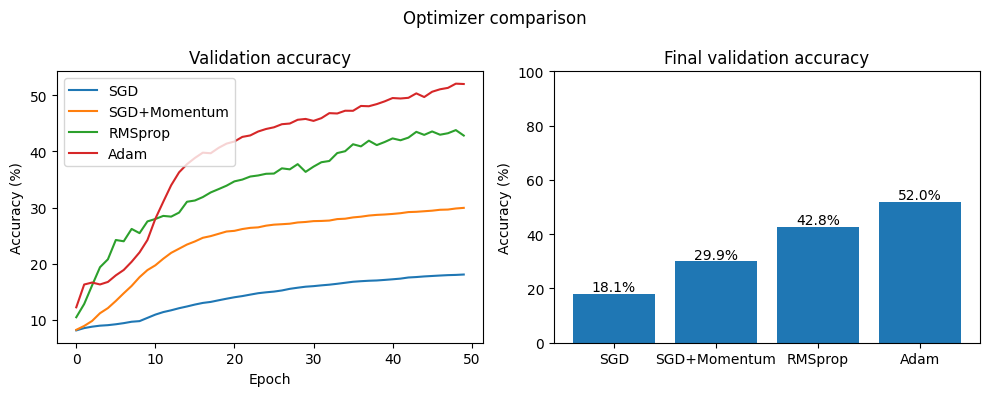

In [14]:
# Plot part 3 results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle(f'Optimizer comparison')

# Validation accuracy over epochs
axes[0].set_title('Validation accuracy')

for name, history in results_part3.items():
    axes[0].plot(history['val_accuracy'], label=name)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()

# Final accuracy bar chart
axes[1].set_title('Final validation accuracy')

names = list(results_part3.keys())
final_accs = [results_part3[n]['val_accuracy'][-1] for n in names]

bars = axes[1].bar(names, final_accs)
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim(0, 100)

# Add value labels
for bar, acc in zip(bars, final_accs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{acc:.1f}%', ha='center')

plt.tight_layout()
plt.show()

## Part 4: Learning rate sensitivity

Learning rates tested: `[0.1, 0.01, 0.001, 0.0001]`

In [ ]:
%%time

results_part4 = {name: {} for name in optimizer_configs.keys()}

for name in optimizer_configs.keys():
    for lr in learning_rates:

        print(f'\nTraining with {name}, lr={lr}')

        results_part4[name][lr] = train_with_optimizer(
            name, lr, n_epochs_part4, print_every=n_epochs_part4 + 1, train_loader=train_loader
        )

        print(f'-> Final val acc: {results_part4[name][lr]["val_accuracy"][-1]:.2f}%')

print()


Training with SGD, lr=0.1
Epoch 1/10 - loss: 2.3505 - accuracy: 11.09% - val_loss: 2.2978 - val_accuracy: 9.48%

Training complete.
-> Final val acc: 28.21%

Training with SGD, lr=0.01
Epoch 1/10 - loss: 2.4029 - accuracy: 9.96% - val_loss: 2.3033 - val_accuracy: 8.75%

Training complete.
-> Final val acc: 21.02%

Training with SGD, lr=0.001
Epoch 1/10 - loss: 2.4251 - accuracy: 9.84% - val_loss: 2.3054 - val_accuracy: 8.12%

Training complete.
-> Final val acc: 10.35%

Training with SGD, lr=0.0001
Epoch 1/10 - loss: 2.4281 - accuracy: 9.82% - val_loss: 2.3057 - val_accuracy: 7.96%

Training complete.
-> Final val acc: 8.19%

Training with SGD+Momentum, lr=0.1
Epoch 1/10 - loss: 2.3397 - accuracy: 11.74% - val_loss: 2.2974 - val_accuracy: 9.48%

Training complete.
-> Final val acc: 35.94%

Training with SGD+Momentum, lr=0.01
Epoch 1/10 - loss: 2.3939 - accuracy: 10.13% - val_loss: 2.3013 - val_accuracy: 9.99%

Training complete.
-> Final val acc: 29.89%

Training with SGD+Momentum, lr

In [ ]:
# Create results matrix for heatmap
optimizer_names = list(optimizer_configs.keys())
accuracy_matrix = np.zeros((len(optimizer_names), len(learning_rates)))

for i, name in enumerate(optimizer_names):
    for j, lr in enumerate(learning_rates):
        accuracy_matrix[i, j] = results_part4[name][lr]['val_accuracy'][-1]

print('Final Validation Accuracy Matrix:')
print()
print(f'{"Optimizer":<15}', end='')

for lr in learning_rates:
    print(f'{lr:>10}', end='')

print()

for i, name in enumerate(optimizer_names):
    print(f'{name:<15}', end='')

    for j, lr in enumerate(learning_rates):
        acc = accuracy_matrix[i, j]
        print(f'{acc:>9.1f}%', end='')

    print()

In [ ]:
# Plot part 4 results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f'Learning rate sensitivity')

# Heatmap
axes[0].set_title('Validation accuracy heatmap')

im = axes[0].imshow(accuracy_matrix, aspect='auto', vmin=10, vmax=70)

axes[0].set_xticks(range(len(learning_rates)))
axes[0].set_xticklabels([str(lr) for lr in learning_rates])
axes[0].set_yticks(range(len(optimizer_names)))
axes[0].set_yticklabels(optimizer_names)
axes[0].set_xlabel('Learning rate')

# Add text annotations
for i in range(len(optimizer_names)):
    for j in range(len(learning_rates)):

        text = f'{accuracy_matrix[i, j]:.1f}%'
        color = 'white' if accuracy_matrix[i, j] < 40 else 'black'
        axes[0].text(j, i, text, ha='center', va='center', color=color, fontsize=11)

plt.colorbar(im, ax=axes[0], label='Validation accuracy (%)')

# Line plot: accuracy vs learning rate
axes[1].set_title('Accuracy vs learning rate')

for name in optimizer_names:
    accs = [results_part4[name][lr]['val_accuracy'][-1] for lr in learning_rates]
    axes[1].plot(range(len(learning_rates)), accs, 'o-', label=name)

axes[1].set_xticks(range(len(learning_rates)))
axes[1].set_xticklabels([str(lr) for lr in learning_rates])
axes[1].set_xlabel('Learning rate')
axes[1].set_ylabel('Validation accuracy (%)')
axes[1].legend()
axes[1].set_ylim(0, 80)

plt.tight_layout()
plt.show()